<a href="https://colab.research.google.com/github/AB0823/Fake-News-Detection-Using-Natural-Language-Process/blob/main/Fake_News_Detection_using_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
import torch

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [5]:
f = pd.read_csv("/content/Fake.csv")
t = pd.read_csv("/content/True.csv")

In [6]:
f["category"] = 1
t["category"] = 0

In [7]:
df = pd.concat([f, t]).reset_index(drop=True)

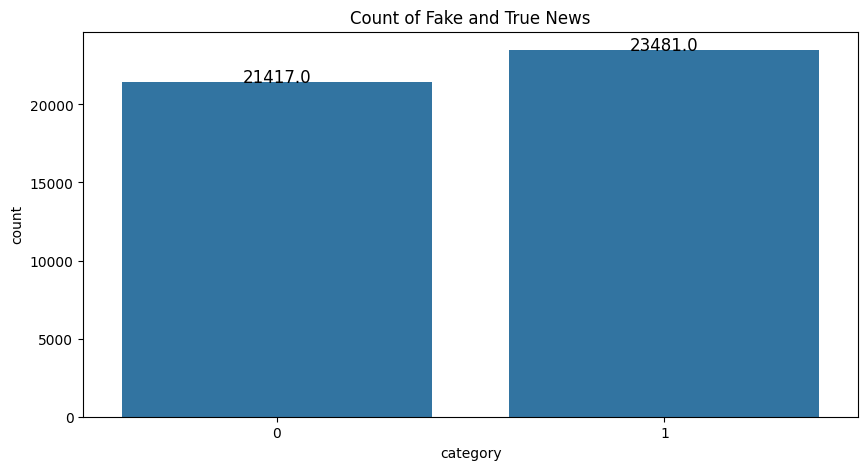

In [8]:
plt.figure(figsize=(10, 5))
graph = sns.countplot(x="category", data=df)
plt.title("Count of Fake and True News")
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x() + p.get_width() / 2., height + 0.2, height, ha="center", fontsize=12)

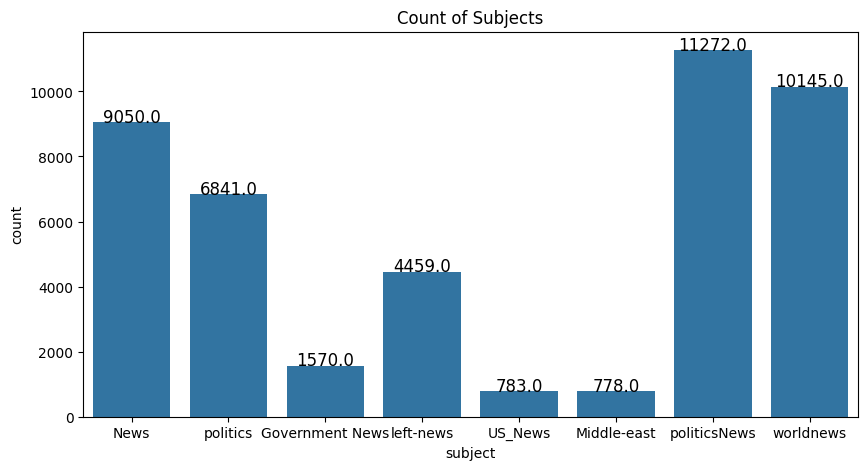

In [9]:
plt.figure(figsize=(10, 5))
graph = sns.countplot(x="subject", data=df)
plt.title("Count of Subjects")
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x() + p.get_width() / 2., height + 0.2, height, ha="center", fontsize=12)

In [10]:
df["text"] = df["title"] + df["text"]
df = df[["text", "category"]]
blanks = [index for index, text in df["text"].items() if isinstance(text, str) and text.isspace()]
print(f"Number of blank (whitespace-only) texts: {len(blanks)}")

Number of blank (whitespace-only) texts: 0


In [11]:
nlp = spacy.load("en_core_web_sm")
lemma = WordNetLemmatizer()
list1 = nlp.Defaults.stop_words
list2 = stopwords.words('english')
Stopwords = set(set(list1) | set(list2))

In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"[-()\"#!@$%^&*{}?.,:]", " ", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    return " ".join(lemma.lemmatize(word) for word in text.split() if word not in Stopwords)

In [13]:
df["text"] = df["text"].apply(clean_text)

In [14]:
X = df["text"]
y = df["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [15]:
train_dataset = Dataset.from_pandas(pd.DataFrame({"text": X_train, "label": y_train}))
test_dataset = Dataset.from_pandas(pd.DataFrame({"text": X_test, "label": y_test}))

In [17]:
model_path = '/content/bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_path, local_files_only=True)
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2, local_files_only=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/30081 [00:00<?, ? examples/s]

Map:   0%|          | 0/14817 [00:00<?, ? examples/s]

In [ ]:
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
#small_train_dataset = train_dataset.select(range(2000))
#small_test_dataset = test_dataset.select(range(1500))

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    logging_dir="./logs",
    logging_steps=50,
    eval_steps=None,
    fp16=True,
    dataloader_num_workers=4,
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
'''
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)'''

In [ ]:
trainer.train()

In [ ]:
eval_results = trainer.evaluate()

print(f"Evaluation results: {eval_results}")

In [ ]:
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))